### Multi-Factor experiment

In [1]:
import pandas as pd
import numpy as np
import os
import factor_calc.util as util

#### Data preparation

In [2]:
path = 'factors'
all_data = pd.read_pickle('all_data.pkl')
stacked_factors = ['beta_daily.pkl', 'beta_opening_hours.pkl', 'beta_closing_hours.pkl', 'rsi.pkl', 'fundamental_factors.pkl']
factor_str_lst = os.listdir(path)
factor_str_lst = list(set(factor_str_lst) - set(stacked_factors))

# merge all factors in all_data
for factor in factor_str_lst:
    if factor.endswith('.pkl'):
        factor_name = factor.split('.')[0]
        factor_data = pd.read_pickle(f'{path}/{factor}')
        # stack factor data to match the format of all_data
        factor_data = factor_data.stack().reset_index()
        factor_data.columns = ['Date', 'Ticker', factor_name]
        util.factor_washing(factor_data, factor_name, window_len=20)
        try:
            all_data = util.df_factor_merge(all_data, factor_data, factor_name=factor_name)
        except Exception as e:
            print(e)
            print(factor_name)

In [3]:
# merging
beta_factors = ['beta_daily.pkl', 'beta_opening_hours.pkl', 'beta_closing_hours.pkl']
for factor in beta_factors:
    factor_name = factor.split('.')[0]
    factor_data = pd.read_pickle(f'{path}/{factor}')
    util.factor_washing(factor_data, factor_name, window_len=20)
    all_data = util.df_factor_merge(all_data, factor_data, factor_name=factor_name)

In [ ]:
print(all_data.head())
print(len(all_data['Date'].unique()))

#### individual raw performance

In [ ]:
factor_name_lst = all_data.columns.to_list()[15:]
factor_name_lst

In [ ]:
index = pd.read_pickle('sp_500.pkl')
all_data_temp = all_data.copy()
for factor_name in factor_name_lst:
    print('\n')
    print(f'-------------------{factor_name}-------------------')
    print('\n')
    util.cal_icir(all_data_temp, factor_name)
    util.group_backtest(all_data_temp, factor_name, group_num=10, index=index)

#### Weighted Average

In [ ]:
factor_name_lst = all_data.columns.to_list()[15:]
factor_name_lst = list(set(factor_name_lst) - set(['beta_closing_hours']))
factor_name_lst

In [ ]:
from tqdm import tqdm

index = pd.read_pickle('sp_500.pkl')
all_data_temp = all_data.copy()
ic_dict = {}
alpha_dict = {}
sharp_dict = {}

for i in tqdm(range(1, len(factor_name_lst))):
    for j in range(i+1, len(factor_name_lst)):
        factor_name1 = factor_name_lst[i]
        factor_name2 = factor_name_lst[j]
        for weight in np.arange(0.1, 1.0, 0.1):
          print('\n')
          print(f'-------------------{factor_name1}*{weight:.1f} & {factor_name2}*{1-weight:.1f}-------------------')
          print('\n')
          all_data_temp['weighted_factor'] = all_data_temp[factor_name1] * weight + all_data_temp[factor_name2] * (1 - weight)
          ic = util.cal_icir(all_data_temp, 'weighted_factor')
          ic_dict[f'{factor_name1}*{weight:.1f} & {factor_name2}*{1-weight:.1f}'] = ic
          return_and_sharpe_dict = util.group_backtest(all_data_temp, 'weighted_factor' , group_num=10, index=index)
          alpha_dict[f'{factor_name1}*{weight:.1f} & {factor_name2}*{1-weight:.1f}'] = return_and_sharpe_dict['annual_alpha']
          sharp_dict[f'{factor_name1}*{weight:.1f} & {factor_name2}*{1-weight:.1f}'] = return_and_sharpe_dict['sharpe']

In [ ]:
ic_temp_dict = {}
for key, value in ic_dict.items():
    ic_temp_dict[key] = np.nanmean(value)

In [ ]:
max_ic = max(ic_temp_dict, key=ic_temp_dict.get)
max_ic, ic_temp_dict[max_ic]

In [ ]:
max_sharpe = max(sharp_dict, key=sharp_dict.get)
max_sharpe, sharp_dict[max_sharpe]

In [ ]:
max_alpha = max(alpha_dict, key=alpha_dict.get)
max_alpha, alpha_dict[max_alpha]

#### IC weighted

current best sharpe ratio combo: high_vol_ratio_daily, beta_opening_hour, HH_vol_factor, exp ic weighted: 
sharpe = 1.2553

current best annual return combo: high_vol_ratio_daily, beta_opening_hour, top_20_volume_return, ic weighted: 
annual return = 0.1197

In [ ]:
factor_name_lst = all_data.columns.to_list()[15:]
factor_name_lst = list(set(factor_name_lst) - set(['beta_closing_hours']))
factor_name_lst

In [ ]:
from tqdm import tqdm

index = pd.read_pickle('sp_500.pkl')
all_data_temp = all_data.copy()
weighted_methods_lst = ['equal', 'ic_weight', 'exp_ic_weight', 'vol_adj']

transaction_cost=0.0005

alpha_dict = {}
sharpe_dict = {}

for i in tqdm(range(1, len(factor_name_lst))):
  for j in range(i+1, len(factor_name_lst)):
    for k in range(j+1, len(factor_name_lst)):

      factor_name1 = factor_name_lst[i]
      factor_name2 = factor_name_lst[j]
      factor_name3 = factor_name_lst[k]

      # calculating ic values and prepare data
      ic_1 = util.cal_icir(all_data_temp, factor_name1, trade_interval='d')
      ic_2 = util.cal_icir(all_data_temp, factor_name2, trade_interval='d')
      ic_3 = util.cal_icir(all_data_temp, factor_name3, trade_interval='d')

      ic_1.rename(columns={'IC': f'{factor_name1}_ic'}, inplace=True)
      ic_2.rename(columns={'IC': f'{factor_name2}_ic'}, inplace=True)
      ic_3.rename(columns={'IC': f'{factor_name3}_ic'}, inplace=True)

      ic_df = pd.merge(ic_1, ic_2, on='Date', how='inner')
      ic_df = pd.merge(ic_df, ic_3, on='Date', how='inner')

      # calculating weighted factor values, try different methods
      for method in weighted_methods_lst:
        all_data_temp = all_data.copy()
        factor_weighted = util.factor_weighted_combine_rolling(all_data_temp, ic_df, [factor_name1, factor_name2, factor_name3], method=method, lookback=20)

        all_data_temp = all_data_temp.merge(factor_weighted, on=['Date', 'Ticker'], how='inner')
        alpha_and_sharpe_dict = util.group_backtest(all_data_temp, 'weighted_factor', group_num=10, index=index, transaction_cost=transaction_cost)

        # record alpha and sharpe values
        alpha_dict[f'{factor_name1} & {factor_name2} & {factor_name3} & {method}'] = alpha_and_sharpe_dict['annual_return']
        sharpe_dict[f'{factor_name1} & {factor_name2} & {factor_name3} & {method}'] = alpha_and_sharpe_dict['sharpe']

In [ ]:
max_alpha = max(alpha_dict, key=alpha_dict.get)
print('max alpha combination: ', max_alpha, alpha_dict[max_alpha])

max_sharpe = max(sharpe_dict, key=sharpe_dict.get)
print('max return combination: ', max_sharpe, sharpe_dict[max_sharpe])

#### Fundamental Factors
current best combo: previous ic-weighted combo 2/3 + ROA * 1/3, sharpe ratio = 1.32

In [ ]:
fundamental_factors = pd.read_pickle('factors/fundamental_factors.pkl')
fundamental_factors.head()

In [ ]:
# don't use first column and last column fundamental factors for now
fund_factors_lst = fundamental_factors.columns.to_list()[3:-1]
print(fund_factors_lst)
# merge fundamental factors
for factor in fund_factors_lst:
    all_data = pd.merge(all_data, fundamental_factors[['Date', 'Ticker', factor]], on=['Date', 'Ticker'], how='inner')

# standardise
for factor in fund_factors_lst:
    all_data[factor] = (all_data[factor] - all_data[factor].mean()) / all_data[factor].std()

In [ ]:
index = pd.read_pickle('sp_500.pkl')
alpha_dict = {}
sharpe_dict = {}

transaction_cost=0

all_data_temp = all_data.copy()

# current best combo with ic_weight method
best_combo = ['low_vol_ratio_daily', 'beta_daily', 'high_vol_ratio_daily']
# best_combo_with_trans_cost = ['beta_opening_hours', 'HH_vol_factor', 'beta_daily']

fund_factor_weight = 1 / len(best_combo)
weighted_factor = util.factor_weighted(all_data_temp, best_combo, lookback=20, method='ic_weight')

for fund_factor in fund_factors_lst:
  all_data_temp = all_data.copy()
  all_data_temp = all_data_temp.merge(weighted_factor, on=['Date', 'Ticker'], how='inner')
  all_data_temp['curr_func_factor_combined'] = all_data_temp[fund_factor] * fund_factor_weight + all_data_temp['weighted_factor'] * (1-fund_factor_weight)

  # run backtest
  print(f'-------------------{fund_factor}-------------------')
  alpha_and_sharpe_dict = util.group_backtest(all_data_temp, 'curr_func_factor_combined', group_num=10, index=index, transaction_cost=transaction_cost)

  # record alpha and sharpe values
  alpha_dict[f'{fund_factor}'] = alpha_and_sharpe_dict['annual_return']
  sharpe_dict[f'{fund_factor}'] = alpha_and_sharpe_dict['sharpe']

In [ ]:
max_alpha = max(alpha_dict, key=alpha_dict.get)
print('max alpha combination: ', max_alpha, alpha_dict[max_alpha])

max_sharpe = max(sharpe_dict, key=sharpe_dict.get)
print('max sharpe combination: ', max_sharpe, sharpe_dict[max_sharpe])

#### Output optimised factor

In [4]:
fundamental_factors = pd.read_pickle('factors/fundamental_factors.pkl')
fundamental_factors.head()

# don't use first column and last column fundamental factors for now
fund_factors_lst = fundamental_factors.columns.to_list()[3:-1]
print(fund_factors_lst)
# merge fundamental factors
for factor in fund_factors_lst:
    all_data = pd.merge(all_data, fundamental_factors[['Date', 'Ticker', factor]], on=['Date', 'Ticker'], how='inner')

# standardise
for factor in fund_factors_lst:
    all_data[factor] = (all_data[factor] - all_data[factor].mean()) / all_data[factor].std()

['RETURN_ON_ASSET', 'RETURN_COM_EQY', 'PE_RATIO', 'PX_TO_SALES_RATIO', 'PX_TO_BOOK_RATIO']


In [ ]:
# testing best combo df

best_combo = ['low_vol_ratio_daily', 'beta_daily', 'high_vol_ratio_daily']
best_fund_factor = 'RETURN_COM_EQY'
index = pd.read_pickle('sp_500.pkl')

all_data_temp = all_data.copy()

fund_factor_weight = 1 / len(best_combo)

weighted_factor = util.factor_weighted(all_data_temp, best_combo, lookback=20, method='ic_weight')
all_data_temp = all_data_temp.merge(weighted_factor, on=['Date', 'Ticker'], how='inner')

all_data_temp['best_factor'] = all_data_temp[best_fund_factor] * fund_factor_weight + all_data_temp['weighted_factor'] * (1-fund_factor_weight)

util.group_backtest(all_data_temp, 'best_factor', group_num=10, index=index)

In [11]:
# output_df = all_data_temp[['Date', 'Ticker', 'best_factor']]
# output_df.to_pickle('new_best_factor.pkl')

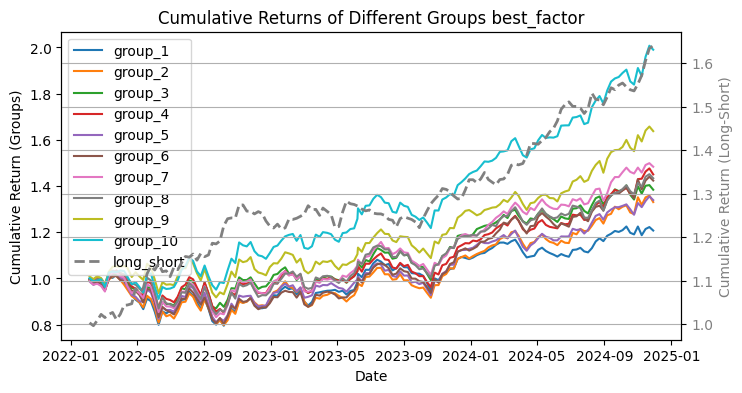


=== Backtesting statistical metrics ===
transaction_cost: 0.00%(single side)
Annualized return:
group_1       0.0780
group_2       0.1119
group_3       0.1251
group_4       0.1406
group_5       0.1144
group_6       0.1350
group_7       0.1486
group_8       0.1367
group_9       0.1820
group_10      0.2483
long_short    0.1703
dtype: float64

Annualized volatility:
group_1       0.1694
group_2       0.1754
group_3       0.1746
group_4       0.1721
group_5       0.1774
group_6       0.1766
group_7       0.1742
group_8       0.1721
group_9       0.1734
group_10      0.1742
long_short    0.0741
dtype: float64

Sharpe ratio:
group_1       0.4604
group_2       0.6380
group_3       0.7165
group_4       0.8170
group_5       0.6449
group_6       0.7644
group_7       0.8530
group_8       0.7943
group_9       1.0496
group_10      1.4254
long_short    2.2982
dtype: float64

max drawback:
group_1      -0.2176
group_2      -0.2101
group_3      -0.1681
group_4      -0.1766
group_5      -0.2095
group_

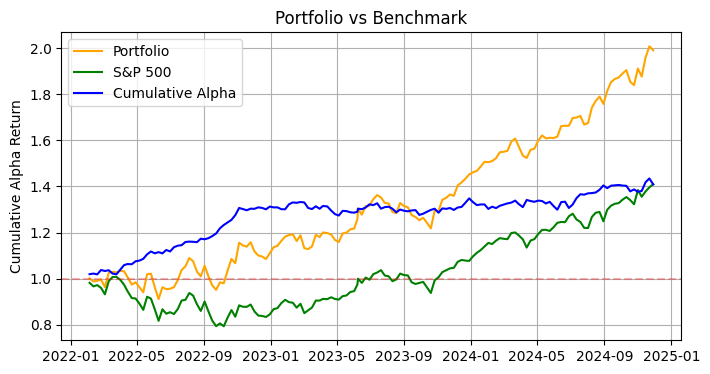


=== Long Group statistical metrics ===
Annualized return: 0.2483
Long volatility: 0.1742
Long sharpe: 1.4254
Long max drawdown: -0.1266

=== Alpha statistical metrics ===
Annualized alpha: 0.1183
Alpha volatility: 0.0688
Alpha sharpe: 1.7195
Alpha max drawdown: -0.0440


{'annual_return': 0.2483, 'sharpe': 1.4254}

In [ ]:
import pandas as pd
import factor_calc.util as util

best_factor = pd.read_pickle('new_best_factor.pkl')
index = pd.read_pickle('sp_500.pkl')
all_data = pd.read_pickle('all_data.pkl')

all_data = pd.merge(all_data, best_factor, on=['Date', 'Ticker'], how='inner')

util.group_backtest(all_data, 'best_factor', group_num=10, index=index)